In [1]:
# Preprocess simulation data from Claudio. This is used for training.
# Author Peter
import h5py
import numpy as np

infile = '/mnt/lts/nfs_fs02/sadow_lab/shared/gcr/data/proposal/data.hdf5'
outfile = '/mnt/lts/nfs_fs02/sadow_lab/shared/gcr/data/proposal/data_processed.hdf5'

In [16]:
# Load, process, write data.
with h5py.File(infile, 'r') as f:
    print([k for k in f])
    print(f['info'])
    print(f['models'])
    dataset = f['models']
    # Remove events that have quality control flag.
    dataset = dataset[dataset['type'] == 0]
    
    X = np.vstack((dataset['alpha'], dataset['cmf'], dataset['cpa'], dataset['pwr1par'], dataset['pwr2par'], dataset['pwr1perr'], dataset['pwr2perr'])).T
    y = np.array(dataset['flux'])
    
print(X.shape, y.shape)

['info', 'models']
<HDF5 dataset "info": shape (1,), type "|V2102">
<HDF5 dataset "models": shape (1655808,), type "|V1018">
(1435308, 7) (1435308, 245)


In [17]:
# Shuffle data.
np.random.seed(0)
shuffle_indices = np.random.permutation(len(y))
X = X[shuffle_indices, :]
y = y[shuffle_indices]

# Write data to new file.
with h5py.File(outfile, 'w') as dest:
    dset = dest.create_dataset("features", data=X)
    dset = dest.create_dataset("flux", data=y)
    dset = dest.create_dataset("logp1_flux", data=np.log(y+1.))
    
# Write data to new file.
with h5py.File('./data_processed_sample.hdf5', 'w') as dest:
    dset = dest.create_dataset("features", data=X[:1000, ...])
    dset = dest.create_dataset("flux", data=y[:1000, ...])
    dset = dest.create_dataset("logp1_flux", data=np.log(1.+y[:1000, ...]))


[ 41.094597    6.4734573 160.1557      1.0845096   1.3110111   1.1005557
   1.2972884] [18.050743    1.3014505  59.27727     0.59793526  0.67795295  0.599881
  0.6823871 ] [20.   4.5 50.   0.2  0.2  0.2  0.2] [ 75.    8.5 250.    2.    2.3   2.    2.3]


(array([408147., 194115., 185187., 177973.,      0.,      0., 166140.,
             0., 153325., 150421.]),
 array([20. , 25.5, 31. , 36.5, 42. , 47.5, 53. , 58.5, 64. , 69.5, 75. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

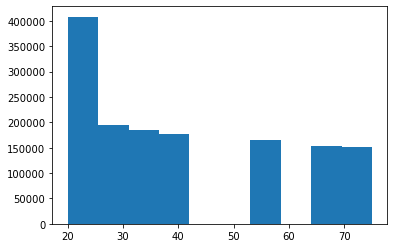

In [6]:
# Statistics.
print(X[:].mean(axis=0), X[:].std(axis=0), X[:].min(axis=0), X[:].max(axis=0))
import matplotlib.pylab as plt
plt.hist(X[:,0].flatten())

In [1]:
# Example usage
import tensorflow_io as tfio # See https://stackoverflow.com/questions/60097970/tensorflow-io-dataset-input-pipeline-with-very-large-hdf5-files
BATCH_SIZE = 3
f = '/mnt/lts/nfs_fs02/sadow_lab/shared/gcr/data/proposal/data_processed.hdf5'
x = tfio.IODataset.from_hdf5(f, dataset='/features')
y = tfio.IODataset.from_hdf5(f, dataset='/flux')
full = tf.data.Dataset.zip((x, y)).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
train = full.take(np.floor(1435308/BATCH_SIZE *.6))
test = full.skip(np.floor(1435308/BATCH_SIZE *.6))

# Print 2 batches.
# for x, y in dataset.take(2).as_numpy_iterator():
#     print(x,y)

2021-10-24 14:08:36.489603: W tensorflow_io/core/kernels/audio_video_mp3_kernels.cc:271] libmp3lame.so.0 or lame functions are not available
2021-10-24 14:08:36.490022: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 AVX512F FMA
2021-10-24 14:08:38.547641: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-24 14:08:42.575466: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2021-10-24 14:08:42.575542: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localho

NameError: name 'tf' is not defined